In [8]:
# import libraries
from cil.optimisation.operators import BlockOperator, GradientOperator, BlurringOperator
from cil.optimisation.functions import ZeroFunction, MixedL21Norm,BlockFunction, L2NormSquared
from cil.optimisation.algorithms import PDHG
from cil.utilities import dataexample
from cil.utilities import noise
from cil.utilities.display import show2D

from skimage.metrics import structural_similarity as ssim

import numpy as np

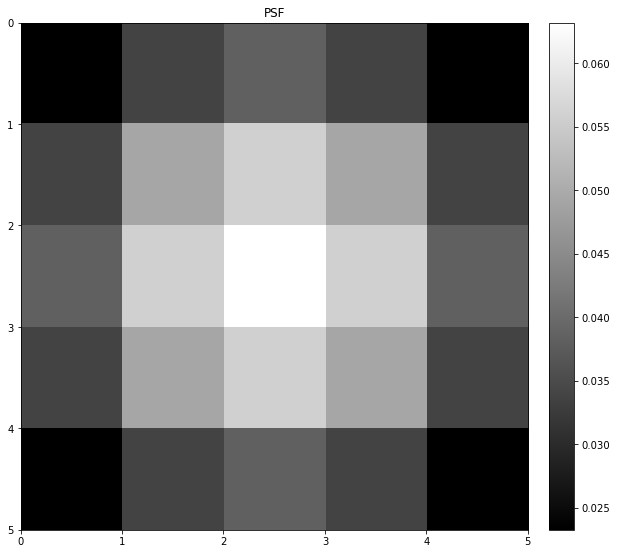

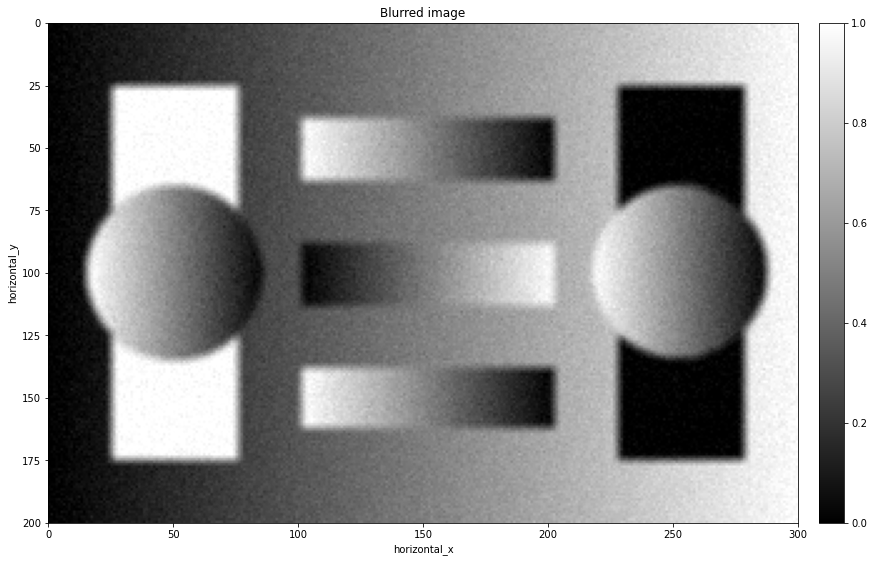

In [10]:
# Load a color image from the CIL gallery.
data= dataexample.SHAPES.get()
ig = data.geometry

# Parameters for point spread function PSF (size and std)
ks          = 5; 
ksigma      = 2.0;

# Create 1D PSF and 2D as outer product, then normalise.
w           = np.exp(-np.arange(-(ks-1)/2,(ks-1)/2+1)**2/(2*ksigma**2))
w.shape     = (ks,1)
PSF         = w*np.transpose(w)
PSF         = PSF/(PSF**2).sum()
PSF         = PSF/PSF.sum()

# Display PSF as image
show2D(PSF, origin="upper", title="PSF")

# Create blurring operator and apply to clean image to produce blurred and display.
# Then add gaussian noise
BOP = BlurringOperator(PSF,ig)
blurred_noisy = noise.gaussian(BOP.direct(data), seed = 10, var = 0.0005)
                                          
show2D(blurred_noisy,origin="upper", title="Blurred+Noisy () image")

In [3]:
# Specify total variation regularised least squares

# Create operators
op1 = GradientOperator(ig, correlation="space")
op2 = BOP

# Set regularisation parameter.
alpha = 0.02

# Create functions to be blocked with operators
f1 = alpha * MixedL21Norm()
f2 = 0.5 * L2NormSquared(b=blurredimage)

# Create BlockOperator
operator = BlockOperator(op1, op2, shape=(2,1) ) 

# Create functions      
f = BlockFunction(f1, f2) 
g = ZeroFunction()
        
# Compute operator Norm
normK = operator.norm()

# Primal & dual stepsizes
sigma = 1/normK
tau = 1/normK

# Setup and run the PDHG algorithm
pdhg = PDHG(f=f,g=g,operator=operator, tau=tau, sigma=sigma,
            max_iteration = 500,update_objective_interval = 100)
pdhg.run(verbose=2)

Initialised GradientOperator with C backend running with  20  threads
PDHG setting up
PDHG configured
     Iter   Max Iter     Time/Iter        Primal          Dual     Primal-Dual
                               [s]     Objective     Objective             Gap
        0        500         0.000    1.01756e+04  -0.00000e+00    1.01756e+04


/opt/anaconda3/envs/cil21_ep/lib/python3.8/site-packages/cil/framework/framework.py:2185: RuntimeWarning: invalid value encountered in true_divide
  pwop(self.as_array(), x2.as_array(), *args, **kwargs )


      100        500         0.010    2.44666e+01   2.12848e+01    3.18185e+00
      200        500         0.009    2.42861e+01   2.34998e+01    7.86264e-01
      300        500         0.009    2.42672e+01   2.39988e+01    2.68378e-01
      400        500         0.009    2.42624e+01   2.41127e+01    1.49737e-01
      500        500         0.009    2.42606e+01   2.41680e+01    9.26531e-02
----------------------------------------------------------------------------
      500        500         0.009    2.42606e+01   2.41680e+01    9.26531e-02
Stop criterion has been reached.



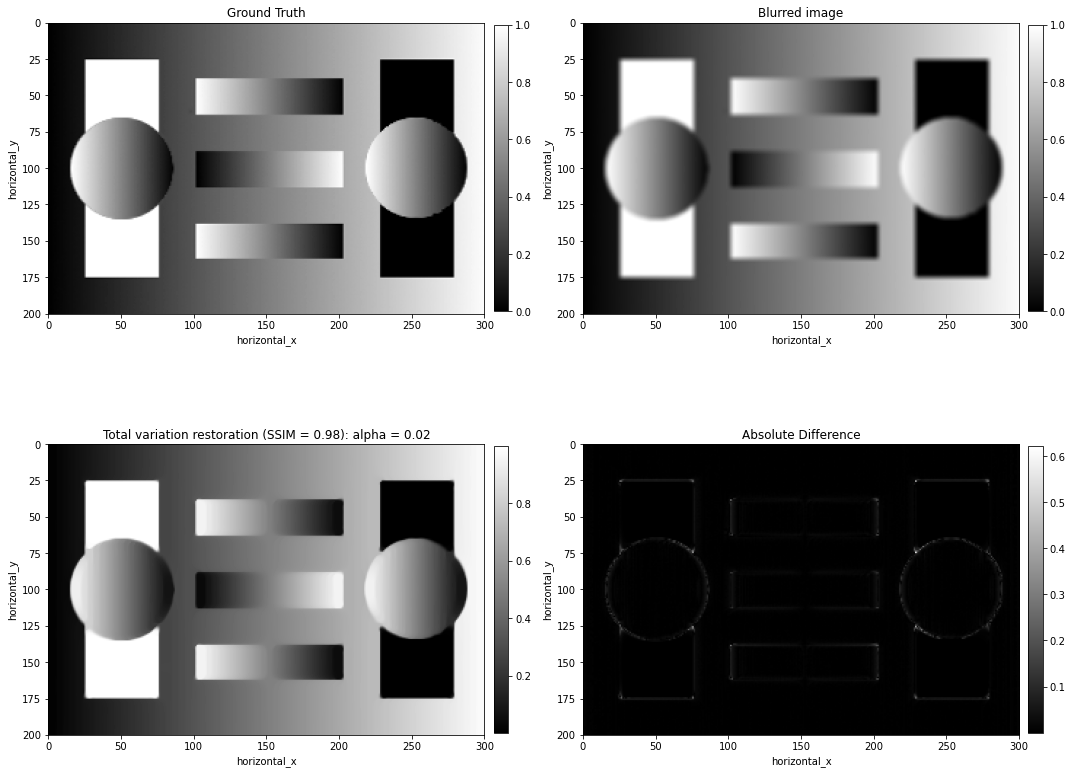

In [6]:
val_ssim = ssim(data.as_array(), pdhg.solution.as_array(), data_range = 1.)
show2D([data, blurredimage, pdhg.solution, (pdhg.solution-data).abs()],
      title=["Ground Truth", 
              "Blurred image", 
              "Total variation restoration (SSIM = {:.2f}): alpha = {}".format(val_ssim, alpha),
              "Absolute Difference"],
     origin = "upper")